# Char RNN Tensorflow in Jupyter

This Jupyter Notebook is based on [this code](https://github.com/sherjilozair/char-rnn-tensorflow) from __Sherjil Ozair__

It implement RNN at char level and is inspired by the _[Minimal character-level Vanilla RNN model](https://gist.github.com/karpathy/d4dee566867f8291f086)_ written by __Andrej Karpathy__ but use TensorFlow 

I did some modifications to the original code to accomodate Jupyter, for instance the orginial code is splited in several files and are optimized to run using parameters from a shell command line.
I added comments, some code to test some parts line by line.

Also I've removed the ability to use LSTM or GRU and the embedings. The results are less impressive than [original code](https://github.com/sherjilozair/char-rnn-tensorflow), but closer to Karpathy's _[Minimal character-level Vanilla RNN model](https://gist.github.com/karpathy/d4dee566867f8291f086)_

Let's dive in :)

## Imports

### Import needed for Tensorflow

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import seq2seq

### Import needed for Jupiter

In [2]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image

### Imports needed for utilities
to load the text and transform it as a vector

In [3]:
import codecs
import os
import collections
from six.moves import cPickle
from six import text_type
import time
from __future__ import print_function

## Args, to define all parameters

The original code use __argparse__ to manage the args.

Here we define a class for it. Feel free to edit to try different settings

In [4]:
class Args():
    def __init__(self):
        '''data directory containing input.txt'''
        self.data_dir = 'data_rnn/tinyshakespeare'
        '''directory to store checkpointed models'''
        self.save_dir = 'save'
        
        '''size of RNN hidden state'''
        self.rnn_size = 128
        '''number of layers in the RNN'''
        self.num_layers = 1 # was 2
        '''minibatch size'''
        self.batch_size = 40
        '''RNN sequence length'''
        self.seq_length = 50
        '''number of epochs'''
        self.num_epochs = 1 # was 5
        '''save frequency'''
        self.save_every = 100 # was 500
        '''Print frequency'''
        self.print_every = 10
        '''clip gradients at this value'''
        self.grad_clip = 5.
        '''learning rate'''
        self.learning_rate = 0.002
        '''decay rate for rmsprop'''
        self.decay_rate = 0.97
        """continue training from saved model at this path. Path must contain files saved by previous training process: 
                            'config.pkl'        : configuration;
                            'chars_vocab.pkl'   : vocabulary definitions;
                            'checkpoint'        : paths to model file(s) (created by tf).
                                                  Note: this file contains absolute paths, be careful when moving files around;
                            'model.ckpt-*'      : file(s) with model definition (created by tf)
                        """
        #self.init_from = 'save'
        self.init_from = None
        
        
        '''number of characters to sample'''
        self.n = 500
        '''prime text'''
        self.prime = u' '
        '''0 to use max at each timestep, 1 to sample at each timestep, 2 to sample on spaces'''
        self.sample = 1


## Load the data

Transforming the original dataset in vector that can be use by a NN is always necessary.

This Class need to be replaced if you want to deal with other kind of data.

This class is able to cache the preprocessed data:
* Check if the data are processed allready
  * if yes load the data using Numpy (not tensorflow)
  * if not
    * process the data
    * save them using Numpy
Process the data

In [5]:
class TextLoader():
    def __init__(self, data_dir, batch_size, seq_length, encoding='utf-8'):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.encoding = encoding

        input_file = os.path.join(data_dir, "input.txt")
        vocab_file = os.path.join(data_dir, "vocab.pkl")
        tensor_file = os.path.join(data_dir, "data.npy")

        if not (os.path.exists(vocab_file) and os.path.exists(tensor_file)):
            print("reading text file")
            self.preprocess(input_file, vocab_file, tensor_file)
        else:
            print("loading preprocessed files")
            self.load_preprocessed(vocab_file, tensor_file)
        self.create_batches()
        self.reset_batch_pointer()

    def preprocess(self, input_file, vocab_file, tensor_file):
        with codecs.open(input_file, "r", encoding=self.encoding) as f:
            data = f.read()
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        with open(vocab_file, 'wb') as f:
            cPickle.dump(self.chars, f)
        self.tensor = np.array(list(map(self.vocab.get, data)))
        np.save(tensor_file, self.tensor)

    def load_preprocessed(self, vocab_file, tensor_file):
        with open(vocab_file, 'rb') as f:
            self.chars = cPickle.load(f)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size *
                                                   self.seq_length))

    def create_batches(self):
        self.num_batches = int(self.tensor.size / (self.batch_size *
                                                   self.seq_length))

        # When the data (tesor) is too small, let's give them a better error message
        if self.num_batches==0:
            assert False, "Not enough data. Make seq_length and batch_size small."

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
        xdata = self.tensor
        ydata = np.copy(self.tensor)
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)

    def next_batch(self):
        x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
        self.pointer += 1
        return x, y

    def reset_batch_pointer(self):
        self.pointer = 0


### Let's see how preprocessing works:

In [6]:
## First we open the file
args = Args()
input_file = os.path.join(args.data_dir, "input.txt")
f =  codecs.open(input_file, "r", 'utf-8')
data = f.read()
print (data[0:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


Then we have:
```python    
counter = collections.Counter(data)
count_pairs = sorted(counter.items(), key=lambda x: -x[1])
chars, _ = zip(*count_pairs)
vocab_size = len(chars)
vocab = dict(zip(chars, range(len(chars))))
```
Witch do the same than this:

```python  
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
vocab = { ch:i for i,ch in enumerate(chars) }
```

Let's see the details here:

In [7]:
counter = collections.Counter(data)
print ('histogram of char from the input data file:', counter)

histogram of char from the input data file: Counter({u' ': 169892, u'e': 94611, u't': 67009, u'o': 65798, u'a': 55507, u'h': 51310, u's': 49696, u'r': 48889, u'n': 48529, u'i': 45537, u'\n': 40000, u'l': 33339, u'd': 31358, u'u': 26584, u'm': 22243, u'y': 20448, u',': 19846, u'w': 17585, u'f': 15770, u'c': 15623, u'g': 13356, u'I': 11832, u'b': 11321, u'p': 10808, u':': 10316, u'.': 7885, u'A': 7819, u'v': 7793, u'k': 7088, u'T': 7015, u"'": 6187, u'E': 6041, u'O': 5481, u'N': 5079, u'R': 4869, u'S': 4523, u'L': 3876, u'C': 3820, u';': 3628, u'W': 3530, u'U': 3313, u'H': 3068, u'M': 2840, u'B': 2761, u'?': 2462, u'G': 2399, u'!': 2172, u'D': 2089, u'-': 1897, u'F': 1797, u'Y': 1718, u'P': 1641, u'K': 1584, u'V': 798, u'j': 628, u'q': 609, u'x': 529, u'z': 356, u'J': 320, u'Q': 231, u'Z': 198, u'X': 112, u'3': 27, u'&': 3, u'$': 1})


In [8]:
count_pairs = sorted(counter.items(), key=lambda x: -x[1])
print (count_pairs)

[(u' ', 169892), (u'e', 94611), (u't', 67009), (u'o', 65798), (u'a', 55507), (u'h', 51310), (u's', 49696), (u'r', 48889), (u'n', 48529), (u'i', 45537), (u'\n', 40000), (u'l', 33339), (u'd', 31358), (u'u', 26584), (u'm', 22243), (u'y', 20448), (u',', 19846), (u'w', 17585), (u'f', 15770), (u'c', 15623), (u'g', 13356), (u'I', 11832), (u'b', 11321), (u'p', 10808), (u':', 10316), (u'.', 7885), (u'A', 7819), (u'v', 7793), (u'k', 7088), (u'T', 7015), (u"'", 6187), (u'E', 6041), (u'O', 5481), (u'N', 5079), (u'R', 4869), (u'S', 4523), (u'L', 3876), (u'C', 3820), (u';', 3628), (u'W', 3530), (u'U', 3313), (u'H', 3068), (u'M', 2840), (u'B', 2761), (u'?', 2462), (u'G', 2399), (u'!', 2172), (u'D', 2089), (u'-', 1897), (u'F', 1797), (u'Y', 1718), (u'P', 1641), (u'K', 1584), (u'V', 798), (u'j', 628), (u'q', 609), (u'x', 529), (u'z', 356), (u'J', 320), (u'Q', 231), (u'Z', 198), (u'X', 112), (u'3', 27), (u'&', 3), (u'$', 1)]


In [9]:
chars, _ = zip(*count_pairs)
print ('chars', chars)

chars (u' ', u'e', u't', u'o', u'a', u'h', u's', u'r', u'n', u'i', u'\n', u'l', u'd', u'u', u'm', u'y', u',', u'w', u'f', u'c', u'g', u'I', u'b', u'p', u':', u'.', u'A', u'v', u'k', u'T', u"'", u'E', u'O', u'N', u'R', u'S', u'L', u'C', u';', u'W', u'U', u'H', u'M', u'B', u'?', u'G', u'!', u'D', u'-', u'F', u'Y', u'P', u'K', u'V', u'j', u'q', u'x', u'z', u'J', u'Q', u'Z', u'X', u'3', u'&', u'$')


In [10]:
vocab_size = len(chars)
print (vocab_size)

65


In [11]:
vocab = dict(zip(chars, range(len(chars))))
print (vocab)

{u'\n': 10, u'!': 46, u' ': 0, u'$': 64, u"'": 30, u'&': 63, u'-': 48, u',': 16, u'.': 25, u'3': 62, u';': 38, u':': 24, u'?': 44, u'A': 26, u'C': 37, u'B': 43, u'E': 31, u'D': 47, u'G': 45, u'F': 49, u'I': 21, u'H': 41, u'K': 52, u'J': 58, u'M': 42, u'L': 36, u'O': 32, u'N': 33, u'Q': 59, u'P': 51, u'S': 35, u'R': 34, u'U': 40, u'T': 29, u'W': 39, u'V': 53, u'Y': 50, u'X': 61, u'Z': 60, u'a': 4, u'c': 19, u'b': 22, u'e': 1, u'd': 12, u'g': 20, u'f': 18, u'i': 9, u'h': 5, u'k': 28, u'j': 54, u'm': 14, u'l': 11, u'o': 3, u'n': 8, u'q': 55, u'p': 23, u's': 6, u'r': 7, u'u': 13, u't': 2, u'w': 17, u'v': 27, u'y': 15, u'x': 56, u'z': 57}


This is equivalent of the following code by Karpathy:
it associate a unique int to any all char used in the file.

In [12]:
# Karpathy ways of 
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
vocab = { ch:i for i,ch in enumerate(chars) }
print (vocab)

{u'\n': 0, u'!': 1, u' ': 2, u'$': 3, u"'": 4, u'&': 5, u'-': 6, u',': 7, u'.': 8, u'3': 9, u';': 10, u':': 11, u'?': 12, u'A': 13, u'C': 14, u'B': 15, u'E': 16, u'D': 17, u'G': 18, u'F': 19, u'I': 20, u'H': 21, u'K': 22, u'J': 23, u'M': 24, u'L': 25, u'O': 26, u'N': 27, u'Q': 28, u'P': 29, u'S': 30, u'R': 31, u'U': 32, u'T': 33, u'W': 34, u'V': 35, u'Y': 36, u'X': 37, u'Z': 38, u'a': 39, u'c': 40, u'b': 41, u'e': 42, u'd': 43, u'g': 44, u'f': 45, u'i': 46, u'h': 47, u'k': 48, u'j': 49, u'm': 50, u'l': 51, u'o': 52, u'n': 53, u'q': 54, u'p': 55, u's': 56, u'r': 57, u'u': 58, u't': 59, u'w': 60, u'v': 61, u'y': 62, u'x': 63, u'z': 64}


Now we have to make a tensor out of the data.

The tensor is done using this:
```python 
tensor = np.array(list(map(vocab.get, data)))
```

Let's split the line to see in details how it works:

In [13]:
data_in_array = map(vocab.get, data)
print (len(data_in_array))
print (data_in_array[0:200])

1115394
[19, 46, 57, 56, 59, 2, 14, 46, 59, 46, 64, 42, 53, 11, 0, 15, 42, 45, 52, 57, 42, 2, 60, 42, 2, 55, 57, 52, 40, 42, 42, 43, 2, 39, 53, 62, 2, 45, 58, 57, 59, 47, 42, 57, 7, 2, 47, 42, 39, 57, 2, 50, 42, 2, 56, 55, 42, 39, 48, 8, 0, 0, 13, 51, 51, 11, 0, 30, 55, 42, 39, 48, 7, 2, 56, 55, 42, 39, 48, 8, 0, 0, 19, 46, 57, 56, 59, 2, 14, 46, 59, 46, 64, 42, 53, 11, 0, 36, 52, 58, 2, 39, 57, 42, 2, 39, 51, 51, 2, 57, 42, 56, 52, 51, 61, 42, 43, 2, 57, 39, 59, 47, 42, 57, 2, 59, 52, 2, 43, 46, 42, 2, 59, 47, 39, 53, 2, 59, 52, 2, 45, 39, 50, 46, 56, 47, 12, 0, 0, 13, 51, 51, 11, 0, 31, 42, 56, 52, 51, 61, 42, 43, 8, 2, 57, 42, 56, 52, 51, 61, 42, 43, 8, 0, 0, 19, 46, 57, 56, 59, 2, 14, 46, 59, 46, 64, 42, 53, 11, 0, 19, 46, 57, 56, 59, 7, 2, 62, 52, 58]


In [14]:
print (data_in_array[0], 'means', data[0],'witch is the first letter in data' )

19 means F witch is the first letter in data


Then we create a numpy array out of it!

In [15]:
tensor = np.array(data_in_array)

### Let's see how batching works:

Here a reminder about the "create batches" function
```python   
def create_batches(self):
    self.num_batches = int(self.tensor.size / (self.batch_size *
                                               self.seq_length))

    # When the data (tesor) is too small, let's give them a better error message
    if self.num_batches==0:
        assert False, "Not enough data. Make seq_length and batch_size small."

    self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
    xdata = self.tensor
    ydata = np.copy(self.tensor)
    ydata[:-1] = xdata[1:]
    ydata[-1] = xdata[0]
    self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
    self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
```

Let's try it:

In [16]:
data_loader = TextLoader(args.data_dir, args.batch_size, args.seq_length)
data_loader.create_batches()
x, y = data_loader.next_batch()
print ('x and y are matrix ', len(x), 'x', len(x[0]) )
print ('there are', len(x), 'batch that contains', len(x[0]), 'chars' )

loading preprocessed files
x and y are matrix  40 x 50
there are 40 batch that contains 50 chars


In [17]:
print ('x[0] is the first set of input:')
print (x[0])
print ('y[0] is the first set of expected output:')
print (y[0])

x[0] is the first set of input:
[49  9  7  6  2  0 37  9  2  9 57  1  8 24 10 43  1 18  3  7  1  0 17  1  0
 23  7  3 19  1  1 12  0  4  8 15  0 18 13  7  2  5  1  7 16  0  5  1  4  7]
y[0] is the first set of expected output:
[ 9  7  6  2  0 37  9  2  9 57  1  8 24 10 43  1 18  3  7  1  0 17  1  0 23
  7  3 19  1  1 12  0  4  8 15  0 18 13  7  2  5  1  7 16  0  5  1  4  7  0]


In [18]:
print ('y[0] is x[0] shifted by one, in other words: y[0][x] == x[0][x+1]')
print ('y[0][10] ==', y[0][10])
print ('x[0][11] ==', x[0][11])

y[0] is x[0] shifted by one, in other words: y[0][x] == x[0][x+1]
y[0][10] == 1
x[0][11] == 1


In [19]:
def identity_initializer():
    def _initializer(shape, dtype=tf.float32):
        return tf.constant(np.identity(shape[0]), dtype)
    return _initializer

## The Model

In [20]:
class Model():
    def __init__(self, args, infer=False):
        self.args = args
        if infer:
            '''Infer is true when the model is used for sampling'''
            args.batch_size = 1
            args.seq_length = 1
        
        # define a cell
        cell = rnn_cell.BasicRNNCell(args.rnn_size)
        self.cell = cell = rnn_cell.MultiRNNCell([cell] * args.num_layers)
        # Input and target are a list of char ID
        self.input_data = tf.placeholder(tf.int32, [args.batch_size, args.seq_length])
        self.targets = tf.placeholder(tf.int32, [args.batch_size, args.seq_length])
        # Intial_state is the state of the internal recurent layer
        self.initial_state = cell.zero_state(args.batch_size, tf.float32)
        # Vectorize is an identity matrix that is used to vectorize a char ID
        # in other words vectorize[char_id] == (zeros(vocal_size)[char_id]=1)
        self.vectorize = tf.constant(np.identity(args.vocab_size), dtype= tf.float32)    
        
        with tf.variable_scope('rnnlm'):
            softmax_w = tf.get_variable("softmax_w", [args.rnn_size, args.vocab_size])
            softmax_b = tf.get_variable("softmax_b", [args.vocab_size])
            with tf.device("/cpu:0"):
                inputs = tf.split(1, args.seq_length, tf.nn.embedding_lookup(self.vectorize, self.input_data))
                inputs = [tf.squeeze(input_, [1]) for input_ in inputs]

        outputs, last_state = seq2seq.rnn_decoder(inputs, self.initial_state, cell, loop_function= None, scope='rnnlm')
        output = tf.reshape(tf.concat(1, outputs), [-1, args.rnn_size])
        self.logits = tf.matmul(output, softmax_w) + softmax_b
        self.probs = tf.nn.softmax(self.logits) # outputs the probability vector
        loss = seq2seq.sequence_loss_by_example([self.logits],
                [tf.reshape(self.targets, [-1])],
                [tf.ones([args.batch_size * args.seq_length])],
                args.vocab_size)
        self.cost = tf.reduce_sum(loss) / args.batch_size / args.seq_length
        self.final_state = last_state
        self.lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),
                args.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))

    def sample(self, sess, chars, vocab, num=200, prime='The ', sampling_type=1):
        state = self.cell.zero_state(1, tf.float32).eval()
        for char in prime[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed)

        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        char = prime[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state:state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            elif sampling_type == 2:
                if char == ' ':
                    sample = weighted_pick(p)
                else:
                    sample = np.argmax(p)
            else: # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = chars[sample]
            ret += pred
            char = pred
        return ret
    
    def inspect(self):
        for var in tf.all_variables():
            if var in tf.trainable_variables():
                print ('t', var.name, var.eval().shape)
            else:
                print ('nt', var.name, var.eval().shape)

### Inspect the model variables
Looking at the shape of use variable can help to understand the flow.  
_'t'_ as a prefix means _trainable_
_'nt'_ as a prefix means _not trainable_

loading preprocessed files
model created
model_checkpoint_path: "save/model.ckpt-556"
all_model_checkpoint_paths: "save/model.ckpt-200"
all_model_checkpoint_paths: "save/model.ckpt-300"
all_model_checkpoint_paths: "save/model.ckpt-400"
all_model_checkpoint_paths: "save/model.ckpt-500"
all_model_checkpoint_paths: "save/model.ckpt-556"

t rnnlm/softmax_w:0 (128, 65)
t rnnlm/softmax_b:0 (65,)
t rnnlm/MultiRNNCell/Cell0/BasicRNNCell/Linear/Matrix:0 (193, 128)
t rnnlm/MultiRNNCell/Cell0/BasicRNNCell/Linear/Bias:0 (128,)
nt Variable:0 ()
nt beta1_power:0 ()
nt beta2_power:0 ()
nt rnnlm/softmax_w/Adam:0 (128, 65)
nt rnnlm/softmax_w/Adam_1:0 (128, 65)
nt rnnlm/softmax_b/Adam:0 (65,)
nt rnnlm/softmax_b/Adam_1:0 (65,)
nt rnnlm/MultiRNNCell/Cell0/BasicRNNCell/Linear/Matrix/Adam:0 (193, 128)
nt rnnlm/MultiRNNCell/Cell0/BasicRNNCell/Linear/Matrix/Adam_1:0 (193, 128)
nt rnnlm/MultiRNNCell/Cell0/BasicRNNCell/Linear/Bias/Adam:0 (128,)
nt rnnlm/MultiRNNCell/Cell0/BasicRNNCell/Linear/Bias/Adam_1:0 (128,

<IPython.core.display.Javascript object>


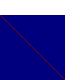

In [21]:
tf.reset_default_graph()
args = Args()
data_loader = TextLoader(args.data_dir, args.batch_size, args.seq_length)
args.vocab_size = data_loader.vocab_size

model = Model(args)
print ("model created")

# Open a session to inspect the model
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

        model.inspect()
        plt.figure(figsize=(1,1))
        plt.figimage(model.vectorize.eval())
        plt.show()

### Visualize the graph

The following code came from the [deepdream jupyter tutorial](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb)  

It allow to draw a graph in Jupyter. It looks cool, but I'm not sure it is usefull.

In [22]:
# this code from:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [23]:
   
# write the graph to help visualizing it
model_fn = 'model.pb'
tf.train.write_graph(sess.graph.as_graph_def(),'.', model_fn, as_text=False) 
    
# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

## Trainning
### loading the data and process them if needed

In [24]:
args = Args()

data_loader = TextLoader(args.data_dir, args.batch_size, args.seq_length)
args.vocab_size = data_loader.vocab_size

# check compatibility if training is continued from previously saved model
if args.init_from is not None:
    print ("need to load file from", args.init_from)
    # check if all necessary files exist 
    assert os.path.isdir(args.init_from)," %s must be a a path" % args.init_from
    assert os.path.isfile(os.path.join(args.init_from,"config.pkl")),"config.pkl file does not exist in path %s"%args.init_from
    assert os.path.isfile(os.path.join(args.init_from,"chars_vocab.pkl")),"chars_vocab.pkl.pkl file does not exist in path %s" % args.init_from
    ckpt = tf.train.get_checkpoint_state(args.init_from)
    assert ckpt,"No checkpoint found"
    assert ckpt.model_checkpoint_path,"No model path found in checkpoint"

    # open old config and check if models are compatible
    with open(os.path.join(args.init_from, 'config.pkl')) as f:
        saved_model_args = cPickle.load(f)
    need_be_same=["model","rnn_size","num_layers","seq_length"]
    for checkme in need_be_same:
        assert vars(saved_model_args)[checkme]==vars(args)[checkme],"Command line argument and saved model disagree on '%s' "%checkme

    # open saved vocab/dict and check if vocabs/dicts are compatible
    with open(os.path.join(args.init_from, 'chars_vocab.pkl')) as f:
        saved_chars, saved_vocab = cPickle.load(f)
    assert saved_chars==data_loader.chars, "Data and loaded model disagreee on character set!"
    assert saved_vocab==data_loader.vocab, "Data and loaded model disagreee on dictionary mappings!"
    print ("config loaded")

with open(os.path.join(args.save_dir, 'config.pkl'), 'wb') as f:
    cPickle.dump(args, f)
with open(os.path.join(args.save_dir, 'chars_vocab.pkl'), 'wb') as f:
    cPickle.dump((data_loader.chars, data_loader.vocab), f)


loading preprocessed files


### Instanciate the model and train it.

In [25]:
tf.reset_default_graph()
model = Model(args)
print ("model created")

with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print ("variable initialized")
    saver = tf.train.Saver(tf.all_variables())
    # restore model
    if args.init_from is not None:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print ("model restored")
    for e in range(args.num_epochs):
        sess.run(tf.assign(model.lr, args.learning_rate * (args.decay_rate ** e)))
        data_loader.reset_batch_pointer()
        state = model.initial_state.eval()
        for b in range(data_loader.num_batches):
            start = time.time()
            # Get learning data
            x, y = data_loader.next_batch()
            # Create the structure for the learning data
            feed = {model.input_data: x, model.targets: y, model.initial_state: state}
            # Run a session using train_op
            train_loss, state, _ = sess.run([model.cost, model.final_state, model.train_op], feed)
            end = time.time()
            if (e * data_loader.num_batches + b) % args.print_every == 0:
                print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}" \
                    .format(e * data_loader.num_batches + b,
                            args.num_epochs * data_loader.num_batches,
                            e, train_loss, end - start))
            if (e * data_loader.num_batches + b) % args.save_every == 0\
                or (e==args.num_epochs-1 and b == data_loader.num_batches-1): # save for the last result
                checkpoint_path = os.path.join(args.save_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = e * data_loader.num_batches + b)
                print("model saved to {}".format(checkpoint_path))

model created
variable initialized
0/557 (epoch 0), train_loss = 4.547, time/batch = 0.248
model saved to save/model.ckpt
10/557 (epoch 0), train_loss = 3.452, time/batch = 0.096
20/557 (epoch 0), train_loss = 3.262, time/batch = 0.136
30/557 (epoch 0), train_loss = 3.262, time/batch = 0.102
40/557 (epoch 0), train_loss = 3.236, time/batch = 0.583
50/557 (epoch 0), train_loss = 3.181, time/batch = 0.583
60/557 (epoch 0), train_loss = 3.040, time/batch = 0.098
70/557 (epoch 0), train_loss = 3.036, time/batch = 0.102
80/557 (epoch 0), train_loss = 2.993, time/batch = 0.094
90/557 (epoch 0), train_loss = 2.870, time/batch = 0.105
100/557 (epoch 0), train_loss = 2.749, time/batch = 0.093
model saved to save/model.ckpt
110/557 (epoch 0), train_loss = 2.718, time/batch = 0.108
120/557 (epoch 0), train_loss = 2.567, time/batch = 0.127
130/557 (epoch 0), train_loss = 2.614, time/batch = 0.132
140/557 (epoch 0), train_loss = 2.498, time/batch = 0.132
150/557 (epoch 0), train_loss = 2.489, time/

## Sampling

In [26]:
tf.reset_default_graph()
model_fn = 'model.pb'

with open(os.path.join(args.save_dir, 'config.pkl'), 'rb') as f:
    saved_args = cPickle.load(f)
with open(os.path.join(args.save_dir, 'chars_vocab.pkl'), 'rb') as f:
    chars, vocab = cPickle.load(f)
    
model = Model(saved_args, True)  # True to generate the model in sampling mode
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
        print(model.sample(sess, chars, vocab, args.n, args.prime, args.sample))

model_checkpoint_path: "save/model.ckpt-556"
all_model_checkpoint_paths: "save/model.ckpt-200"
all_model_checkpoint_paths: "save/model.ckpt-300"
all_model_checkpoint_paths: "save/model.ckpt-400"
all_model_checkpoint_paths: "save/model.ckpt-500"
all_model_checkpoint_paths: "save/model.ckpt-556"

 BakU,:
Tow shes ye;
ffore, Gind ay hiuch og bute to thy mander.

BARAMRI:
I, miind hithse sige s clont ant div
Lo taut fuel's twain; for in thant mereing,
Myot com ile,
In somendid of arll, bothin sprave, armelad. Imjend'lire.

CORIOLO:
Yit, dstade welt mo mat
incty's the Maben yot merpeed dedse be knk ctome.

SAMETULO:
Sh, lorm dono socr aimp! th the? siwrung'?

ADTIS:
Ap, wold wrowe connce,
Bot yepre bendee ad com te pary is by For-
Day,
co belken the berim net.

Shilg feccustongay, breco hand


__That's it!__

If you want to acheive better result, you can increase the number of epoch to 5, the number of layer to 2, switch to LSTM, and add an embeding space. All of this is implemented in the [original code](https://github.com/sherjilozair/char-rnn-tensorflow)

Feedback wellcome __@dh7net__